## Backtesting Framework for Technical Analysis Trading
This project aims to backtest trading results acheived from technical signals generated from indicators. I will break the entire project into three major segments:
### 1) Data extraction and handling
### 2) Signal generation from Technical Indicators
### 3) Performance review with metrics

**Outline of project flow**
1. Fetch historical price data for AAPL, NVDA, GOOG, and META from Yahoo Finance for the past 10 years from period of 2013-01-01 to present date.
2. Create indicator functions to calculate relevant indicator parameters (RSI / MACD / Bollinger Bands).
3. Use the indicator parameters to generate buy / sell signals for any given stock. We shall let the technical signal be:
    o = 'nil',
    1 = 'buy' signal,
    -1 = 'sell' signal

    This means that whenever a stock has indication that it is overbought, we sell with signal -1 and vice versa.

4. Create a backtesting pipeline that utilises the trading signals to execute trades while accounting for transaction costs.
5. Formulate metric calculation function for results input from backtest.
6. Generate metrics.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import datetime as dt

## Data Extraction

In [2]:
# FUNCTION: Fetch historical price data using yfinance
def fetch_data(tickers, start_date, end_date):
    data = {}
    successful = 0
    failed = 0

    for i, ticker in enumerate(tickers):
        try:
            print(f'Fetching {ticker} ({i+1}/{len(tickers)})...', end='\r')
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)

            if df.empty:
                print(f'No data for {ticker}.')
                data[ticker] = None
                failed += 1
            else:
                data[ticker] = df
                successful += 1
                # print(f'Fetch successful for {ticker}!')

        # For debugging purposes:
        except Exception as error:
            print(f'Failed to fetch data for {ticker} with error: {error}')
            data[ticker] = None
            failed += 1

    print(f'\nSuccessful: {successful}\nFailed: {failed}')
    return data

In [28]:
# FUNCTION: Check fetched data info for stocks: (for debugging)
def check_fetched_data(data):
    for ticker in data:
        df = data[ticker]
        if df is not None:
            print(f'Data info for {ticker}:')
            df.info()
            print('\n' + '='*50 + '\n') # Seperator
        else:
            print(f'No data available for {ticker}.\n')
    return 

In [4]:
# Parameters for fetching data
tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
start_date = '2013-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

In [5]:
# Fetch data
data=fetch_data(tickers, start_date, end_date)

Fetching META (4/4)...
Successful: 4
Failed: 0


In [6]:
data

{'AAPL':                                  Open        High         Low       Close  \
 Date                                                                        
 2013-01-02 00:00:00-05:00   16.792421   16.828200   16.422808   16.647182   
 2013-01-03 00:00:00-05:00   16.612306   16.666580   16.403697   16.437050   
 2013-01-04 00:00:00-05:00   16.281509   16.331843   15.943732   15.979208   
 2013-01-07 00:00:00-05:00   15.827607   16.048950   15.621424   15.885218   
 2013-01-08 00:00:00-05:00   16.046216   16.127476   15.804861   15.927963   
 ...                               ...         ...         ...         ...   
 2025-07-18 00:00:00-04:00  210.869995  211.789993  209.699997  211.179993   
 2025-07-21 00:00:00-04:00  212.100006  215.779999  211.630005  212.479996   
 2025-07-22 00:00:00-04:00  213.139999  214.949997  212.229996  214.399994   
 2025-07-23 00:00:00-04:00  215.000000  215.149994  212.410004  214.149994   
 2025-07-24 00:00:00-04:00  213.899994  215.690002  213.

In [7]:
# Check data if any issues
check_fetched_data(data)

Data info for AAPL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3159 entries, 2013-01-02 00:00:00-05:00 to 2025-07-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3159 non-null   float64
 1   High          3159 non-null   float64
 2   Low           3159 non-null   float64
 3   Close         3159 non-null   float64
 4   Volume        3159 non-null   int64  
 5   Dividends     3159 non-null   float64
 6   Stock Splits  3159 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 197.4 KB


Data info for NVDA:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3159 entries, 2013-01-02 00:00:00-05:00 to 2025-07-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3159 non-null   float64
 1   High          3159 non-null   float64
 2   Low           3159 non-null   floa

In [8]:
# FUNCTION: Plot price chart for fetched data
def plot_price_chart(data, start_date, end_date):
    for ticker in tickers:
        df = data[ticker]
        df['Close'].plot(title=f'{ticker} Stock Price', figsize=(7, 4))
        plt.xlabel(f'Date Range: {start_date} - {end_date}')
        plt.ylabel('Close Price (USD)')
        plt.tight_layout()
        plt.show()
    return

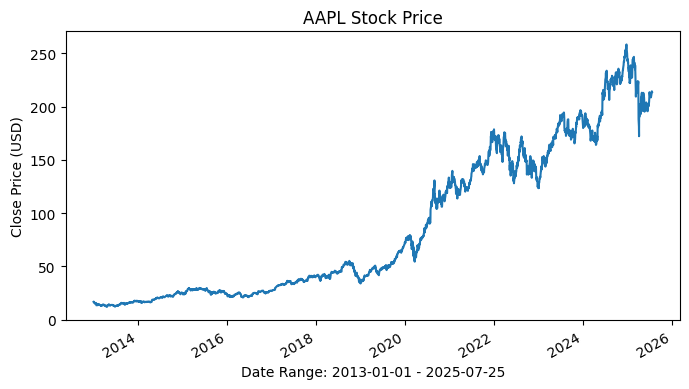

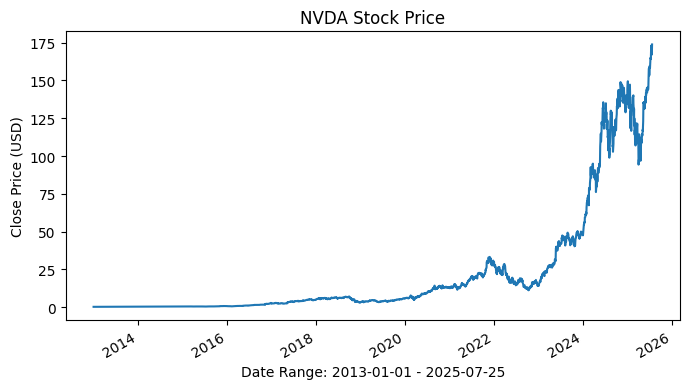

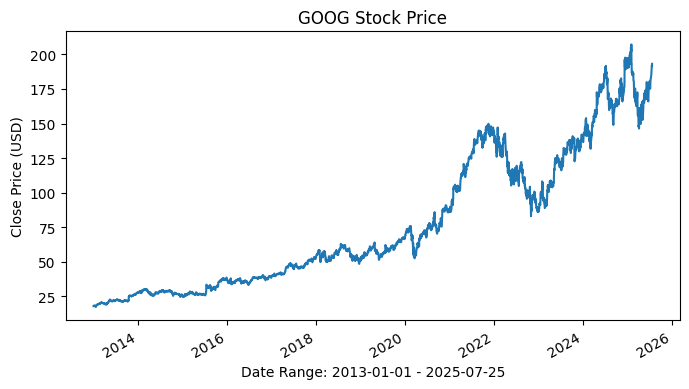

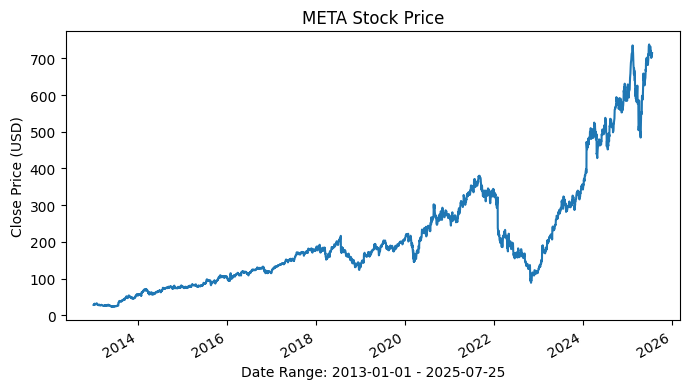

In [9]:
plot_price_chart(data,start_date,end_date)

## Signal Generation from Technical Indicators
Indicators:
- RSI
- MACD

In [10]:
# FUNCTION: RSI Indicator
def rsi_indicator(data, window=14):
    df = data.copy()
    delta = df['Close'].diff() # Difference between consecutive closing prices of tickers
    avg_gain = delta.where(delta > 0, 0).rolling(window=window, min_periods=1).mean() # min_periods=1 to avoid NaNs at the start
    avg_loss = -delta.where(delta < 0, 0).rolling(window=window, min_periods=1).mean()
    avg_loss = avg_loss.replace(0, 1e-10) # Prevent division by zero
    rs = avg_gain / avg_loss
    rsi = 100-(100/(1+rs))
    df['RSI'] = rsi
    return df

![RSI](https://www.alpharithms.com/wp-content/uploads/1674/rsi-formulae-alpharithms-1024x576.jpg)

In [11]:
# FUNCTION: MACD Indicator
def macd_indicator(data, fast=12, slow=26, signal=9):
    df = data.copy()
    fast_ema = df['Close'].ewm(span=fast).mean()
    slow_ema = df['Close'].ewm(span=slow).mean()
    df['MACD'] = fast_ema - slow_ema
    df['MACD_Line'] = df['MACD'].ewm(span=signal).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Line']
    return df

![MACD](https://www.alpharithms.com/wp-content/uploads/1329/macd-trigger-formulas-alpharithms.jpg)

In [12]:
# FUNCTION: Buy / Sell signals generated from RSI indicator
def rsi_signal(data, min=30, max=70):
    df = data.copy()
    rsi = df['RSI']
    if 'RSI' not in df.columns:
        raise KeyError("RSI column is missing!")

    # Discrete signals: nil, 1: buy, -1: sell
    df['RSI_Signal'] = 0
    df.loc[df['RSI'] < min, 'RSI_Signal'] = 1 # buy signal (oversold)
    df.loc[df['RSI'] > max, 'RSI_Signal'] = -1 # sell signal (overbought)

    # Continuous features (normalised)
    df['RSI_Oversold'] = np.maximum(0, min-rsi)/min
    df['RSI_Overbought'] = np.maximum(0, rsi-max)/(100-max)

    # Changes in RSI
    df['RSI_Change'] = rsi.diff()
    return df

In [13]:
def macd_signal(data):
    df = data.copy()
    hist = df['MACD_Histogram']
    if 'MACD_Histogram' not in df.columns:
        raise KeyError("MACD_Histogram column is missing!")

    # Discrete signals: Buy/Sell/Hold
    df['MACD_Signal'] = 0
    df.loc[(df['MACD_Histogram'] > 0) & (df['MACD_Histogram'].shift(1) <= 0), 'MACD_Signal'] = 1
    df.loc[(df['MACD_Histogram'] < 0) & (df['MACD_Histogram'].shift(1) >= 0), 'MACD_Signal'] = -1

    # Continuous features (normalised)
    max_abs_hist = hist.abs().rolling(window=20, min_periods=5).max().replace(0, 1e-10)
    df['MACD_Hist_Score'] = hist / max_abs_hist  # Normalized -1 to 1
    df['MACD_Hist_Direction'] = np.sign(hist.diff())  # +1 = rising, -1 = falling, 0 = flat

    return df


In [14]:
# FUNCTION: RSI Signal Plot
def rsi_signal_plot(tickers, start_date, end_date, min=30, max=70):

    fig, axes = plt.subplots(nrows=len(tickers), ncols=2, figsize=(14, 7 * len(tickers)))
    for i, ticker in enumerate(tickers):
        df = data[ticker]
        
        if df is None:
            continue  # Skip if data is missing for a stock
        
        df = rsi_indicator(df)
        
        # Plot RSI with overbought and oversold levels
        axes[i, 0].plot(df.index, df['RSI'], label='RSI', color='blue')
        axes[i, 0].axhline(y=min, color='red', linestyle='--', label=f'Oversold ({min})')
        axes[i, 0].axhline(y=max, color='green', linestyle='--', label=f'Overbought ({max})')
        axes[i, 0].set_title(f'RSI (Relative Strength Index) for {ticker}')
        axes[i, 0].legend(loc='upper left')
        
        # Buy ('^') and sell ('v') signals in plot
        axes[i, 0].scatter(df.index[df['RSI'] < min], df['RSI'][df['RSI'] < min], color='green', label='Buy Signal', marker='^', alpha=1)
        axes[i, 0].scatter(df.index[df['RSI'] > max], df['RSI'][df['RSI'] > max], color='red', label='Sell Signal', marker='v', alpha=1)
        
        # Historical stock price plot
        axes[i, 1].plot(df.index, df['Close'], label='Close Price', color='black')
        buy_signals = df[df['RSI'] < min]
        axes[i, 1].scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', label='Buy Signal', alpha=1) # Plot Buy signals as makeshift green arrows on the stock price chart
        sell_signals = df[df['RSI'] > max]
        axes[i, 1].scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', label='Sell Signal', alpha=1) # Plot Sell signals as makeshift red arrows on the stock price chart
        axes[i, 1].set_title(f'Stock Close Price for {ticker}')
        axes[i, 1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return

In [15]:
# FUNCTION: MACD Signal Plot
def macd_signal_plot(tickers, start_date, end_date):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=2, figsize=(14, 7*len(tickers)))
    for i, ticker in enumerate(tickers):
        df = data[ticker]
        if df is None:
            continue # Skip if data is missing for a stock

        df = macd_indicator(df)

        # Plot MACD and Signal Line
        axes[i, 0].plot(df.index, df['MACD'], label='MACD', color='blue')
        axes[i, 0].plot(df.index, df['MACD_Line'], label='Signal Line', color='red')
        axes[i, 0].set_title(f'MACD and Signal Line for {ticker}')
        axes[i, 0].legend(loc='upper left')

        # Plot MACD Histogram
        axes[i, 1].bar(df.index, df['MACD_Histogram'], color='gray', label='MACD Histogram')
        axes[i, 1].axhline(0, color='black', linewidth=1)  # Zero line for reference
        axes[i, 1].set_title(f'MACD Histogram for {ticker}')
        axes[i, 1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return

# Visual plots with signals generated from techincal indicators

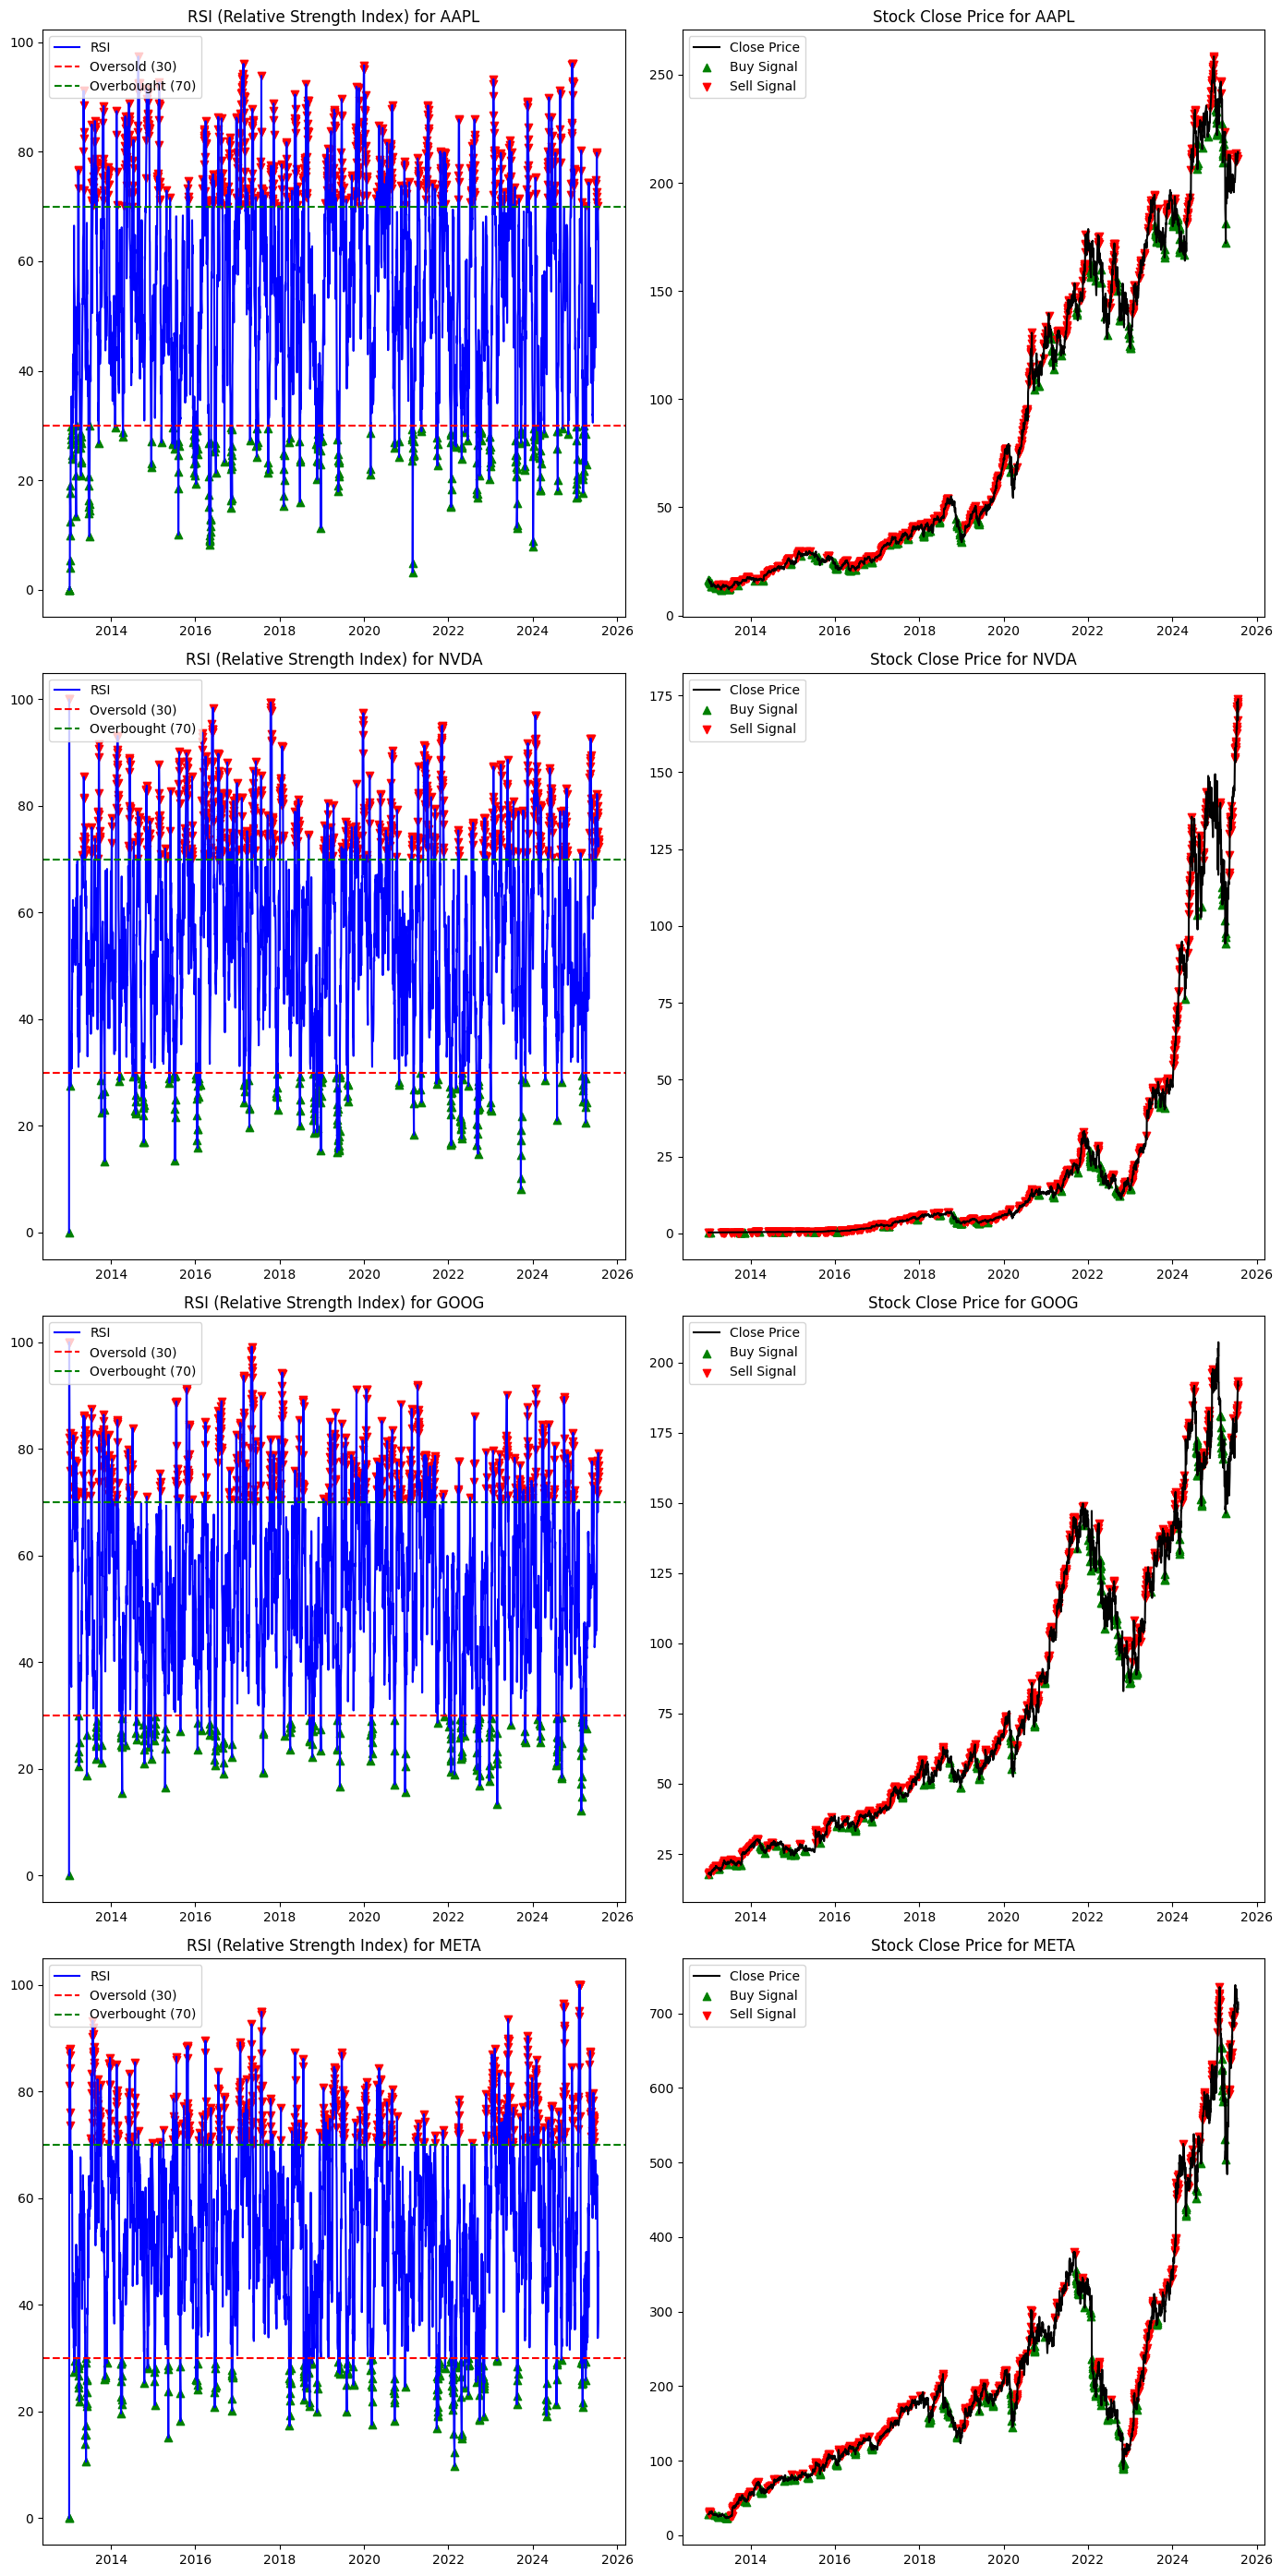

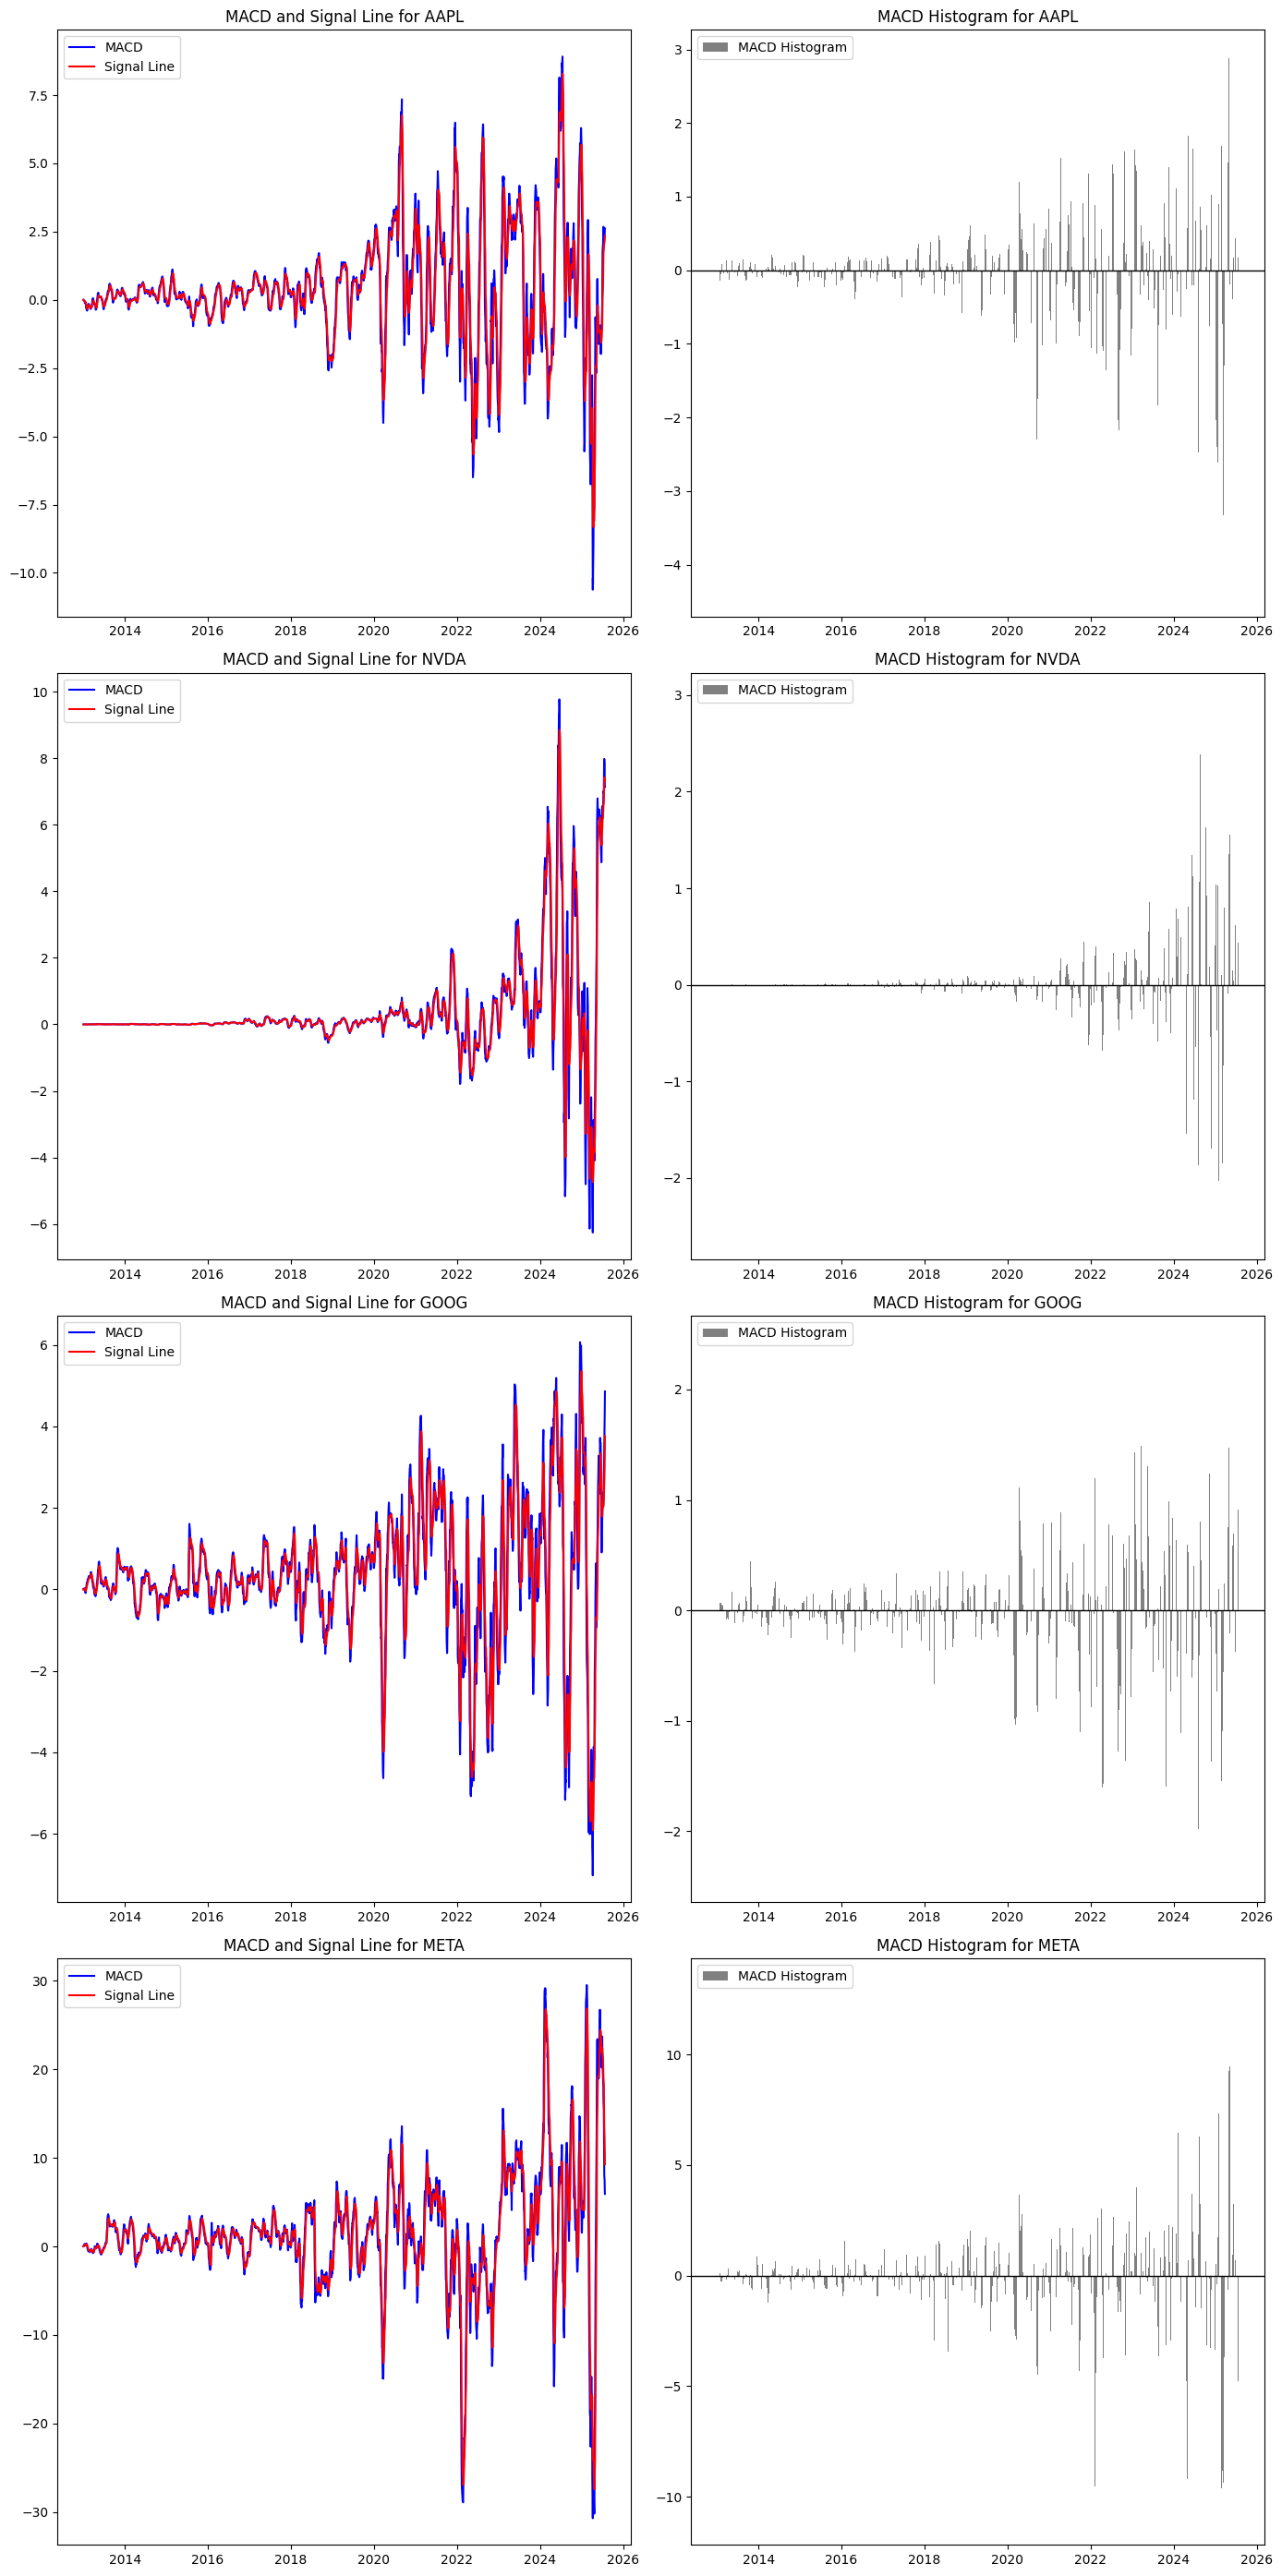

In [16]:
# Parameters for fetching data
tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
start_date = '2013-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

# Plot RSI & MACD signals for all stocks
rsi_signal_plot(tickers, start_date, end_date)
macd_signal_plot(tickers, start_date, end_date)

The signal plots came out nicer as expected, though I notice excessively signalled regions in the RSI. Looking at the RSI signal plot, there may be overcrowded trades to be taken and this may severely impact performance. I'm hoping for a cleaner, more precise trade signalling and we may be able to tune that with the minimum and maximum regions of the RSI. For now, I'll leave it be and check the performance first. Or perhaps I'll constrain this with combined signalling with MACD -- many day traders follow this set-up as well -- where they look for RSI and MACD signals to show strong overbought/sold regions just like a dual-key checkbox.

## Performance Review with Metrics

In [17]:
# FUNCTION: Backtesting pipeline
def backtest_pipeline(data, initial_capital=100_000):
    df = data.copy()
    if 'RSI_Signal' not in df.columns:
        raise KeyError("RSI Signal column is missing!")
    if 'MACD_Signal' not in df.columns:
        raise KeyError("MACD Signal column is missing!")
    
    # Initialise Parameters
    min_trade_value = initial_capital / len(tickers)  # Minimum trade value in dollars
    commission = 0.003
    slippage = 0.000
    transaction_costs = commission + slippage

    # Calculate combined signal
    df['Combined_Signal'] = df['RSI_Signal'].shift(1).fillna(0) * df['MACD_Signal'].shift(1).fillna(0)
    
    # Calculate minimum shares needed for min_trade_value
    df['Min_Shares'] = (min_trade_value / df['Close']).round().astype(int)
    df['Position_Shares'] = df['Combined_Signal'] * df['Min_Shares']
    df['Position_Value'] = df['Position_Shares'] * df['Close']
    df['Mkt_Returns'] = df['Close'].pct_change().fillna(0)
    
    # Position changes
    df['Position_Change'] = df['Position_Shares'].diff().fillna(0)
    df['Trade_Occurred'] = (df['Position_Change'] != 0).astype(int)
    
    # Transaction costs
    df['Position_Value_Change'] = abs(df['Position_Change'] * df['Close'])
    df['Transaction_Costs'] = df['Position_Value_Change'] * transaction_costs
    
    # Calculate dollar returns
    df['Dollar_Returns'] = df['Position_Shares'] * df['Close'].diff().fillna(0) - df['Transaction_Costs']
    
    # Calculate percentage returns for portfolio
    df['Returns'] = df['Dollar_Returns'] / initial_capital
    df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
    df['Cumulative_Capital'] = initial_capital * df['Cumulative_Returns']

    return df

In [18]:
# FUNCTION: Metric calculation from backtest results
def backtest_metrics(returns):

    # Parameters
    trading_days = 252
    n_days = len(returns) # n parameter
    rfr = 0.002
    target_return = 0

    # Calculate returns
    total_return = np.prod(returns + 1) - 1
    annual_return = (1 + total_return) ** (trading_days / n_days) - 1 if (1 + total_return) > 0 else np.nan
    annual_volatility = np.std(returns) * np.sqrt(trading_days) # Sqrt(Variance * trading days)

    # Total number of trades
    total_trades = np.sum(returns != 0)

    # Average return per trade
    avg_trade_return = np.mean(returns[returns != 0]) if total_trades > 0 else np.nan

    # Max drawdown
    cumulative_returns = np.cumprod(returns + 1)
    ath_cumulative = np.maximum.accumulate(cumulative_returns)
    drawdown = (ath_cumulative - cumulative_returns) / ath_cumulative
    max_drawdown = np.max(drawdown)
    
    # Win / Loss
    win_trades = returns[returns > 0]
    win_rate = len(win_trades) / total_trades if total_trades > 0 else np.nan
    avg_win = np.mean(win_trades) if len(win_trades) > 0 else np.nan
    lose_trades = returns[returns < 0]
    lose_rate = len(lose_trades) / total_trades if total_trades > 0 else np.nan
    avg_lose = np.mean(lose_trades) if len(lose_trades) > 0 else np.nan

    # Expectancy
    expectancy = (win_rate * avg_win) + (lose_rate * avg_lose) if win_rate is not np.nan else np.nan


    # Calculate ratios:
    # Sharpe ratio
    sharpe_ratio = (annual_return - rfr) / annual_volatility 

    # Sortino ratio
    downside_returns = returns[returns < target_return]
    downside_volatility = np.std(downside_returns, ddof=1)
    annual_downside_volatility = downside_volatility * np.sqrt(trading_days) if len(downside_returns) > 0 else np.nan
    sortino_ratio = (annual_return - rfr) / annual_downside_volatility if annual_downside_volatility != 0 else np.nan

    return {
        "total_return": total_return,
        "annual_return": annual_return,
        "annual_volatility": annual_volatility,
        "max_drawdown": max_drawdown,
        "total_trades": total_trades,
        "average_return_per_trade": avg_trade_return if not np.isnan(avg_trade_return) else 'N/A',
        "win_rate": win_rate if not np.isnan(win_rate) else 'N/A',
        "expectancy": expectancy if not np.isnan(expectancy) else 'N/A',
        "sharpe_ratio": sharpe_ratio if not np.isnan(sharpe_ratio) else 'N/A',
        "sortino_ratio": sortino_ratio if not np.isnan(sortino_ratio) else 'N/A'
    }

In [19]:
# FUNCTION: Execute everything
def execute():
    # Parameters for fetching data
    tickers = ['AAPL', 'NVDA', 'GOOG', 'META']
    start_date = '2013-01-01'
    end_date = dt.datetime.today().strftime('%Y-%m-%d')

    # Running all functions - indicator, signal, backtest, metrics
    results = {}
    for ticker, df in data.items():
        if df is not None and not df.empty:
            df = rsi_indicator(df)
            df = macd_indicator(df)
            df = rsi_signal(df)
            df = macd_signal(df)
            backtest_results = backtest_pipeline(df)
            metric_results = backtest_metrics(backtest_results['Returns'])
            results[ticker] = metric_results

    # Results display
    results_data = {
        ticker: {
            'Total Return': f"{metric_results['total_return']:.2%}",
            'Annual Return': f"{metric_results['annual_return']:.2%}",
            'Annual Volatility': f"{metric_results['annual_volatility']:.2%}",
            'Maximum Drawdown': f"{metric_results['max_drawdown']:.2%}",
            'Total Trades': metric_results['total_trades'],
            'Average Return Per Trade': f"{metric_results['average_return_per_trade']:.2%}",
            'Win Rate': f"{metric_results['win_rate']:.2%}",
            'Expectancy': f"{metric_results['expectancy']:.4f}",
            '---------- RATIOS ---------- ': f" ",
            'Sharpe Ratio': metric_results['sharpe_ratio'],
            'Sortino Ratio': metric_results['sortino_ratio'],
        } for ticker, metric_results in results.items()
    }
    results_df = pd.DataFrame.from_dict(results_data, orient='columns')
    print(results_df)

In [20]:
execute()

                                   AAPL      NVDA      GOOG      META
Total Return                     -3.41%    -3.90%    -4.26%    -5.20%
Annual Return                    -0.28%    -0.32%    -0.35%    -0.42%
Annual Volatility                 0.70%     0.79%     0.49%     0.61%
Maximum Drawdown                  4.46%     4.28%     4.82%     6.68%
Total Trades                         64        54        52        49
Average Return Per Trade         -0.05%    -0.07%    -0.08%    -0.11%
Win Rate                         25.00%    25.93%    15.38%    10.20%
Expectancy                      -0.0005   -0.0007   -0.0008   -0.0011
---------- RATIOS ----------                                         
Sharpe Ratio                   -0.67987 -0.658459 -1.105842 -1.027792
Sortino Ratio                 -0.136912 -0.118558 -0.199613 -0.175795


Based on the results obtained, we can see that the RSI and MACD strategy only yield negative returns for every stock. This isn't surprising, as all of these stocks are known to be growth stocks -- so reversal strategies hardly works. Nonetheless, the results reflect low profit ratios, poor winning rates and subpar risk, as seen by the underperforming Sharpe and Sortino ratios. The maximum drawdown isn't as low as expected though.

# Kelly's Criterion

![Kelly](https://upload.wikimedia.org/wikipedia/en/b/b6/JohnLKellyJr.PNG)

Yup. This is Kelly. John Larry Kelly Jr. I don't know why I imagined him to be a woman.

In [ ]:
# FUNCTION: Kelly Criterion calculation
def calculate_kelly_fraction(returns, lookback_window=100, method='simple'):
    # Filter out zero returns (no position days)
    active_returns = returns[returns != 0]
    
    if len(active_returns) < 10:  # Need minimum data
        return 0.0
    
    # Use only recent data if specified
    if lookback_window and len(active_returns) > lookback_window:
        active_returns = active_returns[-lookback_window:]
    
    # Calculate win/loss statistics
    wins = active_returns[active_returns > 0]
    losses = active_returns[active_returns < 0]
    
    if len(wins) == 0 or len(losses) == 0:
        return 0.0  # Need both wins and losses
    
    win_rate = len(wins) / len(active_returns)
    loss_rate = len(losses) / len(active_returns)
    avg_win = np.mean(wins)
    avg_loss = abs(np.mean(losses))  # Make positive
    
    if method == 'simple':
        # Simple Kelly: f* = (bp - q) / b
        # where b = avg_win/avg_loss, p = win_rate, q = loss_rate
        if avg_loss == 0:
            return 0.0
        
        b = avg_win / avg_loss  # Odds ratio
        kelly_fraction = (b * win_rate - loss_rate) / b
        
    elif method == 'continuous':
        # Continuous Kelly for normally distributed returns
        mean_return = np.mean(active_returns)
        variance = np.var(active_returns)
        
        if variance == 0:
            return 0.0
        
        kelly_fraction = mean_return / variance
    
    else:
        raise ValueError("Method must be 'simple' or 'continuous'")
    
    # Apply safety constraints
    kelly_fraction = max(0.0, kelly_fraction)  # No negative positions
    kelly_fraction = min(kelly_fraction, 0.25)  # Cap at 25% (quarter Kelly)
    
    return kelly_fraction

![KC](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfCQ2ttA9dCErDwFnE9TueCea5QmiHZR3ecA&s)